### HMM Software
- [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html)
- [pomegranite]()
- [r calculate AIC/BIC of model](https://rdrr.io/cran/HMMpa/man/AIC_HMM.html)
- [comparison between pomegranite and hmmlearn (with notebook)](https://kyso.io/share/pomegranate-vs-hmmlearn#files)
- [discussion of AIC/BIC from hmmlearn](https://waterprogramming.wordpress.com/2018/07/03/fitting-hidden-markov-models-part-ii-sample-python-script/)

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [5]:
import pomegranate
from pomegranate import DiscreteDistribution, HiddenMarkovModel
pomegranate.utils.disable_gpu()

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

### Collect data

In [7]:
DATASET_ID = 'bengalese_finch_sober'

In [8]:
DATA_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data')

In [9]:
syllable_df = pd.concat([pd.read_pickle(i) for i in list((DATA_DIR / 'indv_dfs' / DATASET_ID).glob('*.pickle'))])

In [10]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,rate,spectrogram,syllables_sequence_id,syllables_sequence_pos,umap,hdbscan_labels
0,1.806375,1.828219,-,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_190612_0...,32000,"[[4, 4, 4, 4, 4, 4, 4, 3, 14, 9, 30, 85, 64, 4...",0,0,"[-1.51081, 4.8511953]",5
1,2.173500,2.225844,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_190612_0...,32000,"[[5, 5, 5, 4, 5, 6, 4, 5, 6, 4, 5, 5, 5, 5, 5,...",0,1,"[-0.06860913, 4.332588]",5
2,2.482687,2.550906,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_190612_0...,32000,"[[7, 7, 7, 6, 33, 79, 68, 50, 66, 84, 53, 54, ...",0,2,"[2.1000683, 4.4189005]",5


In [11]:
label = "hdbscan_labels"

#### Compare hdbscan to hand

In [12]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [13]:
indvs = syllable_df.indv.unique()

In [14]:
label_dict = {lab:i for i, lab in enumerate(np.unique(syllable_df['labels'].values))}
syllable_df['labels_num'] = [label_dict[i] for i in syllable_df.labels.values]

gr41rd51


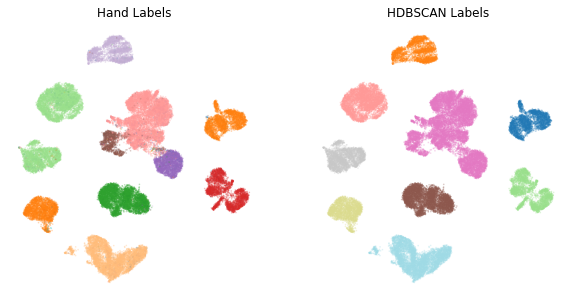

or60yw70


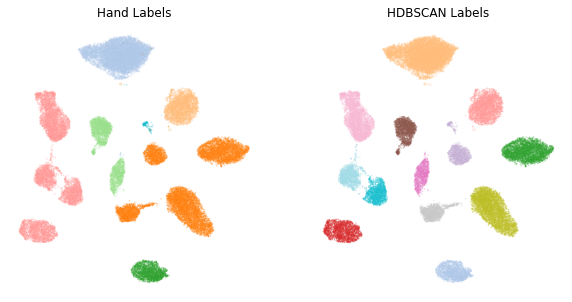

gy6or6


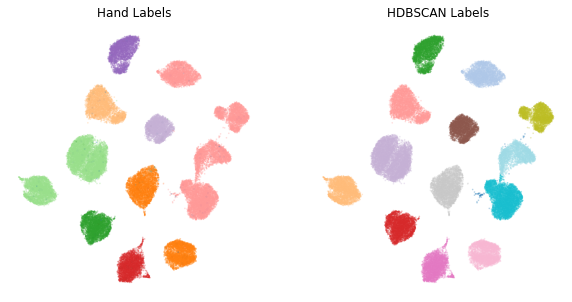

bl26lb16


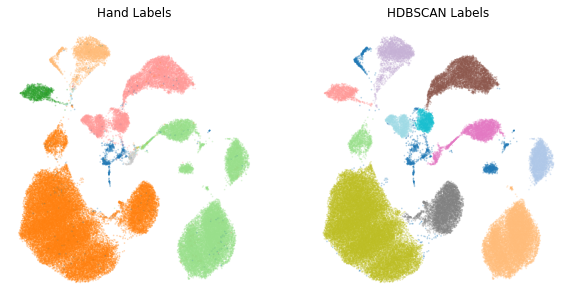

In [15]:
for indv in tqdm(indvs):
    print(indv)
    indv_df = syllable_df[syllable_df.indv == indv]
    z = np.vstack(indv_df.umap.values)
    
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    ax = axs[0]
    ax.scatter(z[:,0], z[:,1], c = indv_df['labels_num'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
    ax.axis('off')
    ax.set_title('Hand Labels')
    ax = axs[1]
    ax.scatter(z[:,0], z[:,1], c = indv_df['hdbscan_labels'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
    ax.set_title('HDBSCAN Labels')
    ax.axis('off')
    plt.show()

### train FOMM on data

In [16]:
indv = 'gy6or6'
indv_df = syllable_df[syllable_df.indv == indv]
indv_df = indv_df.sort_values(by=['syllables_sequence_id', 'syllables_sequence_pos'])
indv_df = indv_df.reset_index()
print(len(indv_df))
indv_df[:3]

56375


,index,start_time,end_time,labels,indv,indvi,key,rate,spectrogram,syllables_sequence_id,syllables_sequence_pos,umap,hdbscan_labels,labels_num
0,0,0.376812,0.447688,i,gy6or6,0,gy6or6_baseline_220312_0836.3,32000,"[[4, 4, 4, 4, 25, 29, 17, 71, 62, 104, 61, 37,...",0,0,"[6.2198596, -2.9278188]",11,11
1,1,0.530594,0.619781,i,gy6or6,0,gy6or6_baseline_220312_0836.3,32000,"[[6, 6, 6, 25, 58, 39, 51, 74, 47, 29, 9, 0, 5...",0,1,"[7.608194, -3.5376432]",11,11
2,2,0.696688,0.835875,i,gy6or6,0,gy6or6_baseline_220312_0836.3,32000,"[[7, 7, 10, 30, 31, 15, 29, 82, 115, 88, 75, 6...",0,2,"[6.9653707, -4.166769]",11,11


#### remove low probability elements

In [17]:
element_prob = {i: np.sum(indv_df.labels_num.values== i) for i in np.unique(indv_df.labels_num.values)}
remove_elements = []
for key, val in element_prob.items():
    if val < 100:
        remove_elements.append(key)
indv_df = indv_df[indv_df.labels_num.isin(remove_elements)==False]
len(indv_df)

56349

### relabel 

In [18]:
unique_states = np.unique(indv_df['labels_num'])
lab_dict = {lab: i for i, lab in enumerate(unique_states)}

# convert seqs to numbers
indv_df['labels_num'] = [lab_dict[i] for i in indv_df['labels_num'].values]

### plot

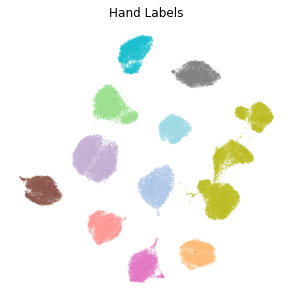

In [19]:
z = np.vstack(indv_df.umap.values)

fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.scatter(z[:,0], z[:,1], c = indv_df['labels_num'], s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.axis('off')
ax.set_title('Hand Labels')

plt.show()

In [20]:
hand_seqs = [
    list(indv_df[indv_df.syllables_sequence_id == seqid]["labels_num"].values)
    for seqid in indv_df.syllables_sequence_id.unique()
]
print(hand_seqs[:3])

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2]]


In [21]:
from hmmlearn import hmm

In [22]:
def AIC(log_likelihood, k):
    """ AIC given log_likelihood and # parameters (k)
    """
    aic = 2 * k - 2 * log_likelihood
    return aic


def BIC(log_likelihood, n, k):
    """ BIC given log_likelihood, number of observations (n) and # parameters (k)
    """
    bic = np.log(n) * k - 2 * log_likelihood
    return bic

In [23]:
seqs = hand_seqs
prop_test = 0.5

In [24]:
def FOMM(seqs, prop_test=0.5):
    """ create a FOMM in pomegranite
    """
    if prop_test == 0:
        seqs_train = seqs_test = seqs
    else:
        # split into train and test for cross validation
        training_mask = np.random.choice(
            np.arange(len(seqs)), size=int(len(seqs) * prop_test), replace=False
        )
        testing_mask = np.array(
            [i for i in np.arange(len(seqs)) if i not in training_mask]
        )

        seqs_train = np.array(seqs)[training_mask]
        seqs_test = np.array(seqs)[testing_mask]

        # make sure test set doesn't contain any data that train doesnt
        assert np.all(
            [
                i in np.unique(np.concatenate(seqs_train))
                for i in np.unique(np.concatenate(seqs_test))
            ]
        )

    # lengths of sequences
    seq_lens = [len(i) for i in seqs_train]

    # get states
    unique_states = np.unique(np.concatenate(seqs_train))

    # get start probabilities
    seq_starts = np.array([i[0] for i in seqs_train])
    start_probs = [np.sum(seq_starts == i) / len(seqs_train) for i in unique_states]

    end_states = [seq[-1] for seq in seqs]
    end_probs = [
        np.sum(end_states == i) / (np.sum(np.concatenate(seqs) == i) + 1)
        for i in np.arange(len(unique_states))
    ]

    # transition probs
    trans_mat = np.zeros((len(unique_states), len(unique_states)))
    for seq in seqs_train:
        for i, j in zip(seq[:-1], seq[1:]):
            trans_mat[i, j] += 1
    # smooth to nonzero probabilities
    trans_mat = (trans_mat.T / trans_mat.sum(axis=1)).T  # np.sum(trans_mat, axis=1)

    # smooth emissions
    emission_prob = np.identity(len(unique_states)) + 1e-5
    emission_prob = (emission_prob.T / emission_prob.sum(axis=1)).T

    # create model
    hmmlearn_model = hmm.MultinomialHMM(n_components=len(unique_states))
    hmmlearn_model.startprob_ = start_probs
    hmmlearn_model.transmat_ = trans_mat
    hmmlearn_model.emissionprob_ = emission_prob

    # test sequence
    test_seq_lens = [len(i) for i in seqs_test]

    # compute log probability
    hmmlearn_log_probability = hmmlearn_model.score(
        np.concatenate(seqs_test).reshape(-1, 1), [len(i) for i in seqs_test]
    )

    # number of datapoints
    n_data = np.sum(test_seq_lens)
    hmmlearn_log_probability

    # initialize pomegranate model

    transmat = hmmlearn_model.transmat_
    start_probs = hmmlearn_model.startprob_
    dists = hmmlearn_model.emissionprob_

    states = [
        DiscreteDistribution({vis: d[i] for i, vis in enumerate(unique_states)})
        for d in dists
    ]
    pom_model = HiddenMarkovModel.from_matrix(
        transition_probabilities=transmat,
        distributions=states,
        starts=start_probs,
        ends=end_probs,  # discluding ends and merge makes models equal log prob
        merge="None",
    )
    pom_model.bake()
    pom_log_probability = np.sum([pom_model.log_probability(seq) for seq in seqs_test])
    

    # number of params in model
    #num_params = (
    #    pom_model.state_count() + pom_model.edge_count() + pom_model.node_count()
    #)
    # number of params in model
    num_params = (
        pom_model.edge_count() + pom_model.node_count() # + pom_model.state_count()  # no hidden states in FOMM
    )

    # AIC and BIC
    aic = AIC(pom_log_probability, num_params)
    bic = BIC(pom_log_probability, n_data, num_params)
    return (
        hmmlearn_model,
        pom_model,
        seqs_train,
        seqs_test,
        hmmlearn_log_probability,
        pom_log_probability,
        num_params,
        n_data,
        aic,
        bic,
    )

In [25]:
n_repeats = 1
results = Parallel(n_jobs=1, verbose=15)(
    delayed(FOMM)(hand_seqs, prop_test=0) for n_components in tqdm(range(n_repeats))
)
results_df_FOMM = pd.DataFrame(
    results,
    columns=[
        "hmmlearn_model",
        "pom_model",
        "seqs_train",
        "seqs_test",
        "hmmlearn_log_probability",
        "pom_log_probability",
        "n_params",
        "n_data",
        "aic",
        "bic",
    ],
)
results_df_FOMM[:3]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


,hmmlearn_model,pom_model,seqs_train,seqs_test,hmmlearn_log_probability,pom_log_probability,n_params,n_data,aic,bic
0,"MultinomialHMM(algorithm='viterbi', init_param...","None:{\n ""class"" : ""State"",\n ""distribut...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...",-14947.544445,-18394.415519,55,56349,36898.831038,37390.493626


In [26]:
(
    hmmlearn_model,
    pom_model,
    seqs_train,
    seqs_test,
    hmmlearn_log_probability,
    pom_log_probability,
    n_params,
    n_data,
    aic,
    bic,
) = results_df_FOMM.iloc[0]

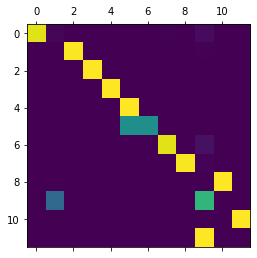

In [27]:
plt.matshow(hmmlearn_model.transmat_)

In [28]:
print(hand_seqs[2])

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2]


In [29]:
pom_model.sample()

array([ 9,  1,  2,  3,  4,  5,  5,  5,  6,  7,  8, 10, 11,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11,
        9,  9,  9,  9,  9,  9,  9,  9,  1,  2,  3,  4,  5,  6,  7,  8, 10,
       11,  9,  1,  2])

In [30]:
print(aic, bic, pom_log_probability)

36898.83103834659 37390.493625866075 -18394.415519173293


### HDBSCAN as hidden labels

In [31]:
# relable HDBSCAN to discrete numbers
unique_states = np.unique(indv_df['hdbscan_labels'])
lab_dict = {lab: i for i, lab in enumerate(unique_states)}

# convert seqs to numbers
indv_df['hdbscan_labels_num'] = [lab_dict[i] for i in indv_df['hdbscan_labels'].values]

In [32]:
latent_seqs = [
    list(indv_df[indv_df.syllables_sequence_id == seqid]["hdbscan_labels_num"].values)
    for seqid in indv_df.syllables_sequence_id.unique()
]
print(hand_seqs[:3])

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 9, 9, 9, 1, 2, 3, 4, 5, 5, 6, 9, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2, 3, 4, 5, 5, 6, 7, 8, 10, 11, 9, 1, 2]]


In [33]:
def fit_fixed_latent(seqs, latent_seqs):

    unique_latent_labels = np.unique(np.concatenate(latent_seqs))
    n_components = len(unique_latent_labels)

    # convert latent sequences to correct format
    label_seqs_str = [
        ["None-start"] + ["s" + str(i) for i in seq] + ["None-end"]
        for seq in latent_seqs
    ]

    pom_model = HiddenMarkovModel.from_samples(
        distribution=DiscreteDistribution,
        n_components=len(unique_latent_labels),
        X=seqs,
        labels=label_seqs_str,
        end_state=True,
        algorithm="labeled",
        verbose=True,
    )

    log_prob = [pom_model.log_probability(seq) for seq in seqs]
    
    sum_log_prob = np.sum(log_prob)

    num_params = (
        pom_model.state_count() + pom_model.edge_count() + pom_model.node_count()
    )

    n_data = np.sum([len(i) for i in seqs])

    aic = AIC(sum_log_prob, num_params)
    bic = BIC(sum_log_prob, n_data, num_params)

    return pom_model, log_prob, sum_log_prob, n_components, num_params, n_data, aic, bic

In [34]:
n_repeats = 1
results = Parallel(n_jobs=1, verbose=15)(
    delayed(fit_fixed_latent)(hand_seqs, latent_seqs) for i in tqdm(range(n_repeats))
)
results_df_umap_hidden = pd.DataFrame(
    results,
    columns=[
        "pom_model",
        "log_prob",
        "sum_log_prob",
        "n_components",
        "num_params",
        "n_data",
        "aic",
        "bic",
    ],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1] Improvement: 122422.56266878197	Time (s): 0.1883
[2] Improvement: 0.0	Time (s): 0.1903
Total Training Improvement: 122422.56266878197
Total Training Time (s): 0.6480



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


In [35]:
results_df_umap_hidden

,pom_model,log_prob,sum_log_prob,n_components,num_params,n_data,aic,bic
0,"None:{\n ""class"" : ""State"",\n ""distribut...","[-16.87914517043269, -20.166382737577138, -29....",-15675.894762,14,256,56349,31863.789525,34152.255387


In [36]:
model = results_df_umap_hidden.pom_model.values[0]

In [37]:
model.sample()

array([ 9,  9,  9,  9,  9,  9,  9,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11,
        9,  1,  2,  3,  4,  5,  5,  6,  7,  8, 10, 11])

### Use second order states as labels

In [38]:
# get second order states
seqs_second_order = [
    [
        str(seq[i - 1]) + "-" + str(element)
        if i > 0
        else str("start") + "-" + str(element)
        for i, element in enumerate(seq)
    ]
    for seq in seqs
]
unique_second_order_labels = np.unique(np.concatenate(seqs_second_order))
# convert to numbers
state_conversion_dict = {state: num for num, state in enumerate(unique_second_order_labels)}
#seqs_second_order_states = [['None-start'] + [state_conversion_dict[i] for i in seq] + ['None-end'] for seq in seqs_second_order]
seqs_second_order_states = [[state_conversion_dict[i] for i in seq]  for seq in seqs_second_order]

In [39]:
n_repeats = 1
results = Parallel(n_jobs=1, verbose=15)(
    delayed(fit_fixed_latent)(hand_seqs, seqs_second_order_states) for i in tqdm(range(n_repeats))
)
results_df_second_order_hidden = pd.DataFrame(
    results,
    columns=[
        "pom_model",
        "log_prob",
        "sum_log_prob",
        "n_components",
        "num_params",
        "n_data",
        "aic",
        "bic",
    ],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1] Improvement: 142218.98711664136	Time (s): 0.2753
[2] Improvement: 0.0	Time (s): 0.2761
Total Training Improvement: 142218.98711664136
Total Training Time (s): 0.9727



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


In [40]:
results_df_second_order_hidden

,pom_model,log_prob,sum_log_prob,n_components,num_params,n_data,aic,bic
0,"None:{\n ""class"" : ""State"",\n ""distribut...","[-11.665009378676906, -13.003660756570763, -22...",-9002.637255,29,961,56349,19927.274509,28517.960811


In [41]:
model = results_df_umap_hidden.pom_model.values[0]

In [42]:
model.sample()

array([ 9,  9,  9,  9,  9,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11,  9,  1,
        2,  3,  4,  5,  6,  7,  8, 10, 11,  9,  9,  9,  9,  1,  2,  3,  4,
        5,  5,  5,  6,  7,  8, 10, 11,  9,  1,  2,  3,  4,  5,  6,  7,  8,
       10, 11,  9,  1,  9,  9,  9])

### Fit HMM

In [43]:
def fit_hmm(
    seqs,
    n_components,
    prop_test=0.5,
    verbose=False,
    pom_stop_threshold=1e-8,
    pom_max_iterations=1e8,
):

    # split train and test
    if prop_test == 0:
        seqs_train = seqs_test = seqs
    else:
        # split into train and test for cross validation
        training_mask = np.random.choice(
            np.arange(len(seqs)), size=int(len(seqs) * prop_test), replace=False
        )
        testing_mask = np.array(
            [i for i in np.arange(len(seqs)) if i not in training_mask]
        )

        seqs_train = np.array(seqs)[training_mask]
        seqs_test = np.array(seqs)[testing_mask]

        # make sure test set doesn't contain any data that train doesnt
        assert np.all(
            [
                i in np.unique(np.concatenate(seqs_train))
                for i in np.unique(np.concatenate(seqs_test))
            ]
        )

    # lengths of sequences
    seq_lens = [len(i) for i in seqs_train]

    # get states
    unique_states = np.unique(np.concatenate(seqs_train))

    # model
    hmmlearn_model = hmm.MultinomialHMM(n_components=n_components, verbose=verbose).fit(
        np.concatenate(seqs_train).reshape(-1, 1), [len(i) for i in seqs_train]
    )

    # probability of data given model
    hmmlearn_log_probability = hmmlearn_model.score(
        np.concatenate(seqs_test).reshape(-1, 1), [len(i) for i in seqs_test]
    )

    # hidden labels
    hmmlearn_predictions = [
        hmmlearn_model.predict(np.array(seq).reshape(-1, 1)) for seq in seqs
    ]

    # probability of ending in state, for each state (for pom)
    hmmlearn_end_states = np.array([i[-1] for i in hmmlearn_predictions])
    end_probs = [
        np.sum(hmmlearn_end_states == i)
        / (np.sum(np.concatenate(hmmlearn_predictions) == i) + 1)
        for i in np.arange(n_components)
    ]

    # initialize pom
    transmat = hmmlearn_model.transmat_
    start_probs = hmmlearn_model.startprob_
    dists = hmmlearn_model.emissionprob_

    states = [
        DiscreteDistribution({vis: d[i] for i, vis in enumerate(unique_states)})
        for d in dists
    ]
    pom_model = HiddenMarkovModel.from_matrix(
        transition_probabilities=transmat,
        distributions=states,
        starts=start_probs,
        ends=end_probs,  # discluding ends and merge makes models equal log prob
        merge="None",
    )

    # fit pom model
    improvement = pom_model.fit(
        seqs_train,
        max_iterations=pom_max_iterations,
        verbose=verbose,
        algorithm="baum-welch",
        stop_threshold=pom_stop_threshold,
        n_jobs=1,
    )

    pom_log_probability = np.sum([pom_model.log_probability(seq) for seq in seqs_test])

    pom_predictions = [pom_model.predict(seq) for seq in seqs]

    num_params = pom_model.state_count() + pom_model.edge_count() + pom_model.node_count()
    
    n_data = np.sum([len(i) for i in seqs_test])
    
    aic = AIC(pom_log_probability, num_params)
    bic = BIC(pom_log_probability, n_data, num_params)

    return (
        n_components,
        hmmlearn_model,
        pom_model,
        seqs_train,
        seqs_test,
        hmmlearn_predictions,
        pom_predictions,
        num_params,
        hmmlearn_log_probability,
        pom_log_probability,
        aic,
        bic,
    )

In [44]:
n_repeats = 5
results = Parallel(n_jobs=-1, verbose=15)(
    delayed(fit_hmm)(
        hand_seqs,
        n_components,
        prop_test = 0.0,
        verbose=False,
        pom_stop_threshold=1e-1,
        pom_max_iterations=1e3,
    )
    for n_components in tqdm(
        np.random.permutation(np.repeat(np.arange(15, 45, 2), n_repeats))
    )
)
results_df = pd.DataFrame(
    results,
    columns=[
        "n_components",
        "hmmlearn_model",
        "pom_model",
        "seqs_train",
        "seqs_test",
        "hmmlearn_predictions",
        "pom_predictions",
        "n_params",
        "hmmlearn_log_probability",
        "pom_log_probability",
        "aic",
        "bic",
    ],
)
results_df[:3]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.8min


[Parallel(n_jobs=-1)]: Done  18 out of  75 | elapsed:  5.6min remaining: 17.7min
[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  7.2min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done  30 out of  75 | elapsed:  9.7min remaining: 14.6min
[Parallel(n_jobs=-1)]: Done  36 out of  75 | elapsed: 11.5min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done  42 out of  75 | elapsed: 12.8min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done  48 out of  75 | elapsed: 13.8min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  54 out of  75 | elapsed: 15.1min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 16.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 18.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  72 out of  75 | elapsed: 21.5min remaining:   53.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 27.5min finished


,n_components,hmmlearn_model,pom_model,seqs_train,seqs_test,hmmlearn_predictions,pom_predictions,n_params,hmmlearn_log_probability,pom_log_probability,aic,bic
0,41,"MultinomialHMM(algorithm='viterbi', init_param...","None:{\n ""class"" : ""State"",\n ""distribut...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[10, 10, 10, 10, 10, 10, 10, 10, 10, 39, 13, ...","[[31, 31, 1, 1, 1, 2, 2, 37, 37, 33, 5, 0, 3, ...",1824,-9456.998173,-8115.831114,19879.662227,36184.981493
1,21,"MultinomialHMM(algorithm='viterbi', init_param...","None:{\n ""class"" : ""State"",\n ""distribut...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, ...","[[10, 10, 10, 10, 6, 6, 6, 6, 6, 12, 13, 18, 9...",519,-31465.124736,-8941.138839,18920.277678,23559.784640
2,39,"MultinomialHMM(algorithm='viterbi', init_param...","None:{\n ""class"" : ""State"",\n ""distribut...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4, 5,...","[[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, ...","[[15, 15, 4, 4, 33, 33, 28, 13, 13, 29, 12, 35...",1657,-10886.333012,-8046.295885,19406.591769,34219.044633


In [45]:
(
    n_components,
    hmmlearn_model,
    pom_model,
    seqs_train,
    seqs_test,
    hmmlearn_predictions,
    pom_predictions,
    n_params,
    hmmlearn_log_probability,
    pom_log_probability,
    aic,
    bic,
) = results_df.iloc[np.argmax(results_df.bic.values)]

In [46]:
print(pom_model.sample())

[ 9  9  9  9  9  9  9  9  9  9  9  9  9  1  2  3  6  7  8 10 11  9  1  2
  3  4  5  8 10 11  9  1  2  3  6  5  8 10 11  9  9  9  9  9  1]


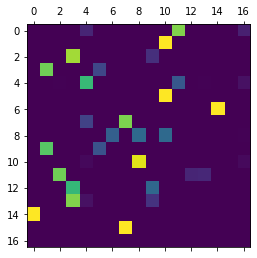

In [47]:
plt.matshow(pom_model.dense_transition_matrix())

### plot results

In [48]:
import seaborn as sns

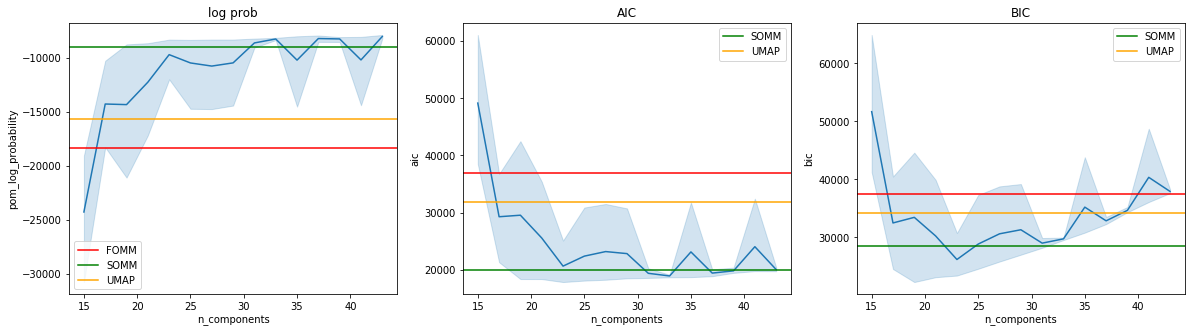

In [49]:
fig, axs = plt.subplots(ncols =3, figsize=(20,5))
ax = axs[0]
sns.lineplot(x = "n_components", y = "pom_log_probability",data=results_df, ax = ax)
#ax.scatter(results_df.n_components, results_df.log_prob)
#ax.plot(results_df.n_components, results_df.log_prob)
ax.axhline(np.mean(results_df_FOMM.pom_log_probability.values), color='red', label='FOMM')
ax.axhline(np.mean(results_df_second_order_hidden.sum_log_prob.values), color='green', label='SOMM')
ax.axhline(np.mean(results_df_umap_hidden.sum_log_prob.values), color='orange', label='UMAP')
ax.set_title('log prob')
ax.legend()

ax = axs[1]
#ax.scatter(results_df.n_components, results_df.AIC)
sns.lineplot(x = "n_components", y = "aic", data=results_df, ax = ax)
#ax.plot(results_df.n_components, results_df.AIC)
ax.set_title('AIC')
ax.axhline(np.mean(results_df_FOMM.aic.values), color='red', label='FOMM')
ax.axhline(np.mean(results_df_second_order_hidden.aic.values), color='green', label='SOMM')
ax.axhline(np.mean(results_df_umap_hidden.aic.values), color='orange', label='UMAP')
ax.legend()

ax = axs[2]
#ax.scatter(results_df.n_components, results_df.BIC)
sns.lineplot(x = "n_components", y = "bic",  data=results_df, ax = ax)
#ax.plot(results_df.n_components, results_df.BIC)
ax.axhline(np.mean(results_df_FOMM.bic.values), color='red', label='FOMM')
ax.set_title('BIC')
ax.axhline(np.mean(results_df_second_order_hidden.bic.values), color='green', label='SOMM')
ax.axhline(np.mean(results_df_umap_hidden.bic.values), color='orange', label='UMAP')
ax.legend()

### choose best HMM based on BIC, compare to FOMM

In [50]:
BIC_df = results_df[['n_components', 'bic']].groupby('n_components').describe()
BIC_df.T

n_components            15            17            19            21  \
bic count         5.000000      5.000000      5.000000      5.000000   
    mean      51680.428135  32464.973250  33433.246688  30224.441231   
    std       15111.054192  10106.704336  15582.966377  10838.821550   
    min       35382.380711  22292.227118  21904.566247  22518.998279   
    25%       43314.780591  22617.759425  22003.702932  23325.158669   
    50%       48818.967169  32423.725587  23506.057642  23559.784640   
    75%       55676.728332  40637.920038  44023.768388  34064.454062   
    max       75209.283873  44353.234081  55728.138232  47653.810507   

n_components            23            25            27            29  \
bic count         5.000000      5.000000      5.000000      5.000000   
    mean      26155.487457  28821.827013  30591.626822  31290.975816   
    std        5149.817048   9481.302411   9116.201058   8765.627875   
    min       23121.160655  24527.610353  25144.019704  26818.952555   
    25%       23374.567323  24564.574468  25681.548439  26872.213152   
    50%       23915.437138  24613.347649  26832.011516  27540.603223   
    75%       25099.826425  24621.242632  28571.417289  28288.043565   
    max       35266.445746  45782.359963  46729.137165  46935.066584   

n_components            31            33            35            37  \
bic count         5.000000      5.000000      5.000000      5.000000   
    mean      28980.940190  29718.748657  35196.444476  32833.691531   
    std        1072.355164    283.832025   9613.936328    760.755119   
    min       28038.721324  29329.724054  30703.142692  32182.515046   
    25%       28200.899472  29567.643398  30756.633943  32281.446631   
    50%       28424.273191  29791.512134  31004.196621  32424.809897   
    75%       29806.627173  29822.895483  31126.699474  33395.872288   
    max       30434.179790  30081.968215  52391.549650  33883.813794   

n_components            39            41            43  
bic count         5.000000      5.000000      5.000000  
    mean      34642.899387  40341.208890  37904.619545  
    std         620.262387   9368.779701    433.063604  
    min       34219.044633  35991.431517  37534.662675  
    25%       34384.172292  36150.295915  37648.305523  
    50%       34387.524022  36184.981493  37737.646812  
    75%       34484.498242  36279.775081  37980.996329  
    max       35739.257747  57099.560443  38621.486387

In [51]:
n_comp = BIC_df['bic']['mean'].argmin()
BIC_mean = BIC_df['bic']['mean'].min()
BIC_std = BIC_df.loc[n_comp]['bic']['std']

n_comp, BIC_mean, BIC_std

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


(23, 26155.487457297917, 5149.817048120058)

In [52]:
np.mean(results_df_FOMM.bic), np.std(results_df_FOMM.bic)

(37390.493625866075, 0.0)

### color by HMM states

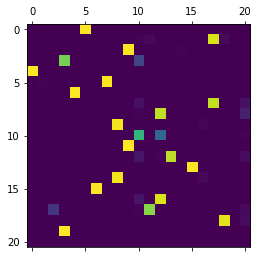

In [53]:
best_row = np.argmin(results_df.bic.values)# results_df.iloc[np.argmax(results_df.log_prob.values)] 
(
    n_components,
    hmmlearn_model,
    pom_model,
    seqs_train,
    seqs_test,
    hmmlearn_predictions,
    pom_predictions,
    n_params,
    hmmlearn_log_probability,
    pom_log_probability,
    aic,
    bic,
) =  results_df.iloc[best_row] 

plt.matshow(pom_model.dense_transition_matrix())

In [54]:
indv_df[:3]

,index,start_time,end_time,labels,indv,indvi,key,rate,spectrogram,syllables_sequence_id,syllables_sequence_pos,umap,hdbscan_labels,labels_num,hdbscan_labels_num
0,0,0.376812,0.447688,i,gy6or6,0,gy6or6_baseline_220312_0836.3,32000,"[[4, 4, 4, 4, 25, 29, 17, 71, 62, 104, 61, 37,...",0,0,"[6.2198596, -2.9278188]",11,9,12
1,1,0.530594,0.619781,i,gy6or6,0,gy6or6_baseline_220312_0836.3,32000,"[[6, 6, 6, 25, 58, 39, 51, 74, 47, 29, 9, 0, 5...",0,1,"[7.608194, -3.5376432]",11,9,12
2,2,0.696688,0.835875,i,gy6or6,0,gy6or6_baseline_220312_0836.3,32000,"[[7, 7, 10, 30, 31, 15, 29, 82, 115, 88, 75, 6...",0,2,"[6.9653707, -4.166769]",11,9,12


In [55]:
z = np.vstack(indv_df.umap.values)

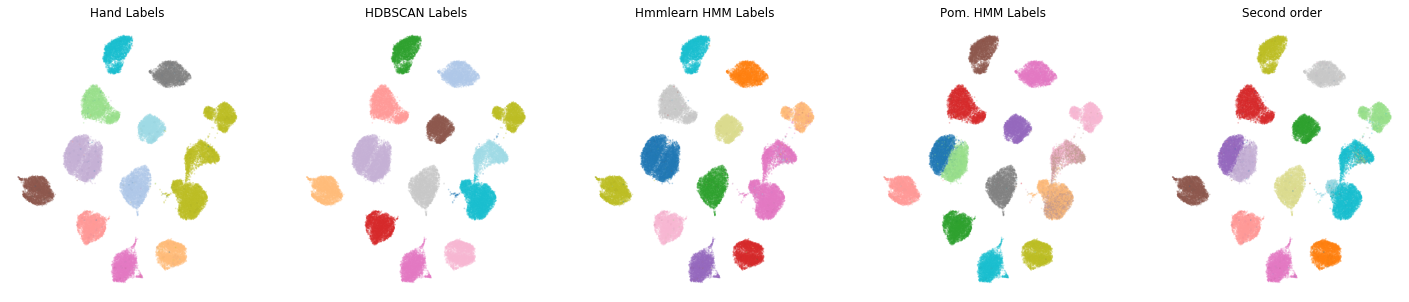

In [56]:
fig, axs = plt.subplots(ncols=5, figsize=(25,5))
ax = axs[0]
ax.scatter(z[:,0], z[:,1], c = indv_df['labels_num'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.axis('off')
ax.set_title('Hand Labels')

ax = axs[1]
ax.scatter(z[:,0], z[:,1], c = indv_df['hdbscan_labels'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('HDBSCAN Labels')
ax.axis('off')

ax = axs[2]
ax.scatter(z[:,0], z[:,1], c = np.concatenate(hmmlearn_predictions), s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('Hmmlearn HMM Labels')
ax.axis('off')

ax = axs[3]
ax.scatter(z[:,0], z[:,1], c = np.concatenate(pom_predictions), s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('Pom. HMM Labels')
ax.axis('off')

ax = axs[4]
ax.scatter(z[:,0], z[:,1], c = np.concatenate(seqs_second_order_states), s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('Second order')
ax.axis('off')

plt.show()